In [1]:
import sys
sys.path.append(
    r"C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\Decodingv7")
sys.path.append(
    r"C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\tnsbmi")
sys.path.append(
    r"C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\tnspython")

from ax.modelbridge.generation_strategy import (
    GenerationStep, GenerationStrategy)
from ax import (Arm, ChoiceParameter, ComparisonOp, Data, FixedParameter,
                Metric, Models, Objective, OptimizationConfig,
                OutcomeConstraint, Parameter, ParameterType, RangeParameter,
                Runner, SearchSpace, SimpleExperiment)
import pandas as pd
import numpy as np
import hydra
import os
import json
import logging
import warnings
from ax import save
from ax.service.ax_client import AxClient
from ax.storage.runner_registry import register_runner
from preprocessing.data import get_alignOn, get_timesteps, load_data, split_data
from preprocessing.parameters import Preprocessing_DefaultParameters
from modeling.defaults import (CLASSIFIERS, FEATURE_EXTRACTORS,
                               PREPROCESSORS, FILTERING_SCORERS,
                               OUTLIER_DETECTORS)
from modeling.pipeline_builder import PipelineBuilder
from modeling.pipelines import PIPELINES, ExplorationPipeline
from omegaconf import DictConfig, OmegaConf
from preprocessing.ratesTransformer import RatesTransformer
from preprocessing.reachTuningTransformer import ReachTuningTransformer
from sklearn.model_selection import train_test_split
from tnsbmi import dataconversion
from tnsbmi.binning import Bin
from ax import load
import pickle
from optimization.utils import (SearchSpaceGen, get_diff_dict, GetBestParameters,
                                load_best_config, configure_model, 
                                configure_optimization, get_default_params,
                                run_experiment)

import seaborn as sns
from math import ceil
from plotting.utils import *
from plotting.plots import visualize_embeddings, components_pairplot, components_violinplot
%matplotlib inline
sns.set_context("notebook")


# Parameters

In [2]:
root_dir = (
    r"C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\outputs\different_objects\vgrasp_Sky_20200928_1312_B_trials\Anova_RF\Anova_Times_IForest_RF_neg_log_loss\Default\2021-01-05_19-00-27"
)
metric = "accuracy"
k = 6
embedder = "lda"

In [3]:
# Parameters
root_dir = "C:\\Users\\jesga\\OneDrive\\Desktop\\NeuroscienceLeuven\\Code\\outputs\\different_objects\\vgrasp_Sky_20200928_1312_B_trials/Anova_RF/Anova_Times_RF_neg_log_loss/Default/2020-12-31_15-41-23"
metric = "accuracy"
k = 6
embedder = "lda"


# Loading Opt Results

In [4]:
opt_parameters = load_best_config(root_dir, metric)
cfg_path = os.path.join(root_dir,".hydra","config.yaml")
cfg = OmegaConf.load(cfg_path)
# Fix for old experiments
cfg.base_optimization = cfg.get('base_optimization', True)
cfg.model = cfg.get("model","basic_decoder")

[INFO 01-08 13:25:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 55_0


[INFO 01-08 13:25:06] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\Decodingv7\optimization\utils.py:100: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Set-Up

In [5]:
# Data loading
trials, labels = load_data(cfg.data.data_path)
labels_set = set(labels)
# Loading train data
trials_train, trials_test, y_train, y_test = split_data(trials, labels, return_test=True)

# Create data dict
data_dict = {
    "train": {
        "X": trials_train, "y": y_train
    },
    "test": {
        "X": trials_test, "y": y_test
    }
}

In [6]:
# Setting model catalogue
available_steps = {**PREPROCESSORS, **FEATURE_EXTRACTORS, **CLASSIFIERS}
available_scorers = FILTERING_SCORERS
# Setting optimization parameters
basic_params, extended_params = configure_optimization(cfg)
# Default params
default_params = get_default_params(cfg, basic_params)
# Define pipeline
model_pipeline = PipelineBuilder(available_steps, available_scorers)
model_pipeline = model_pipeline.fit(cfg.pipeline.pipeline_arch)
# Set of model params(basic + best from experiment)
params = {**default_params, **opt_parameters}
# Get model parameters
if cfg.base_optimization:
    model_params = [model_pipeline, cfg.metric_dict, default_params]
else:
    model_params = [
        model_pipeline,
        OUTLIER_DETECTORS[cfg.extensions.outlier.outlier_detector],
        cfg.extensions.outlier.insert_stage,
        cfg.metric_dict,
        default_params
    ]

# Init model
model = configure_model(cfg, PIPELINES, *model_params)
# Add training data to model
model = model.set_data(trials_train, y_train)
# Fit model
models = model.define_models(opt_parameters)
if (type(models) == tuple):
    model, filter_model = model.define_models(opt_parameters)
    model = model.fit(trials_train, y_train)
    filter_model = filter_model.fit(trials_train, y_train)

else:
    model = models.fit(trials_train, y_train)


# Exploration Pipeline

In [7]:
exp_pipe = ExplorationPipeline(model, data_dict)

# Preprocessing

In [8]:
pipeline_arch = cfg.pipeline.pipeline_arch
step = get_step_name(pipeline_arch, "preprocessing", "kbest")
df_preprocessing = exp_pipe.processed_data_df(step)

In [9]:
cols_to_use = preprocessing_col_filter(df_preprocessing, model, k)

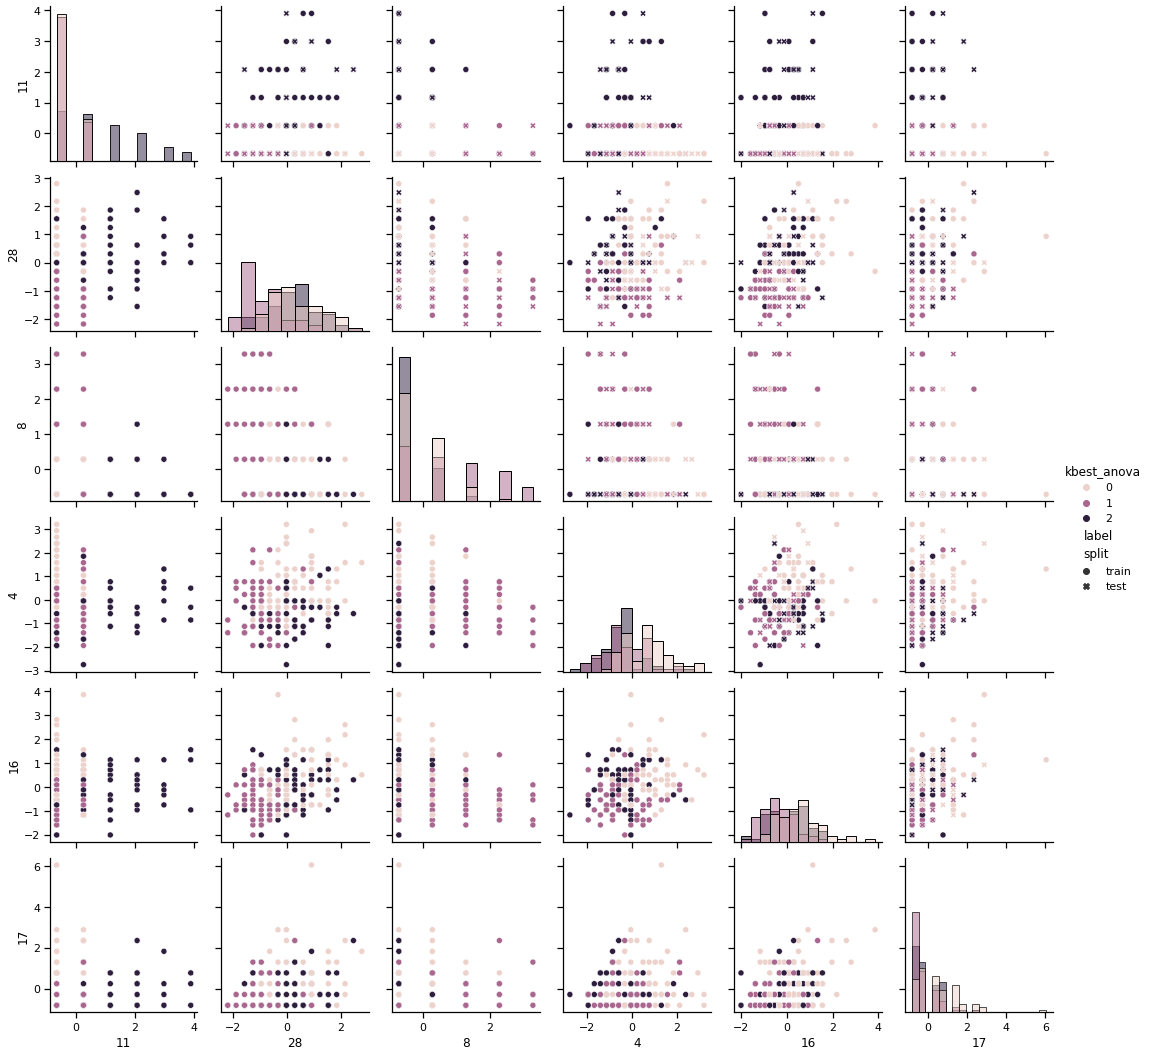

In [10]:
title = step.split("__")[-1]
components_pairplot(
    df_preprocessing, 
    cols_to_use,
    title=title,
    with_test=True
)

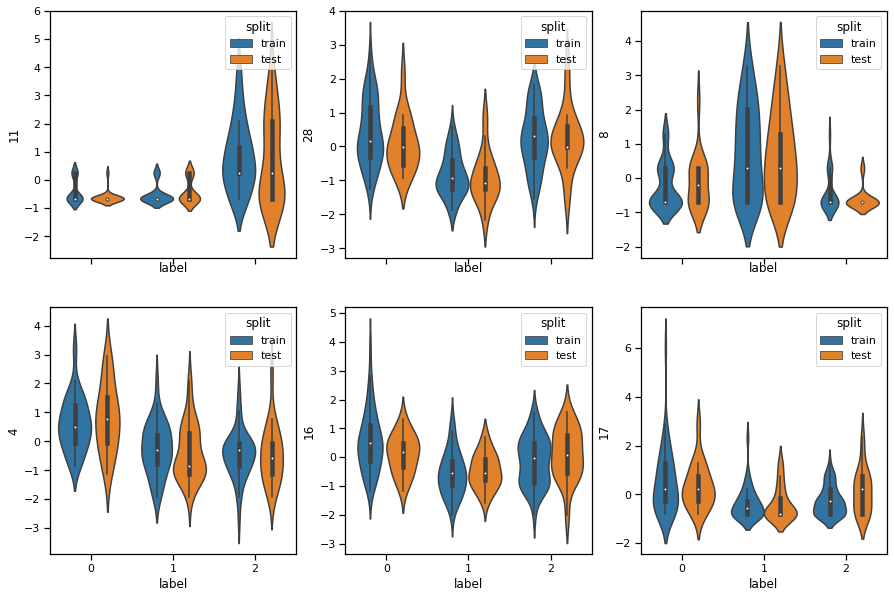

In [11]:
components_violinplot(df_preprocessing, cols_to_use, with_test = True)

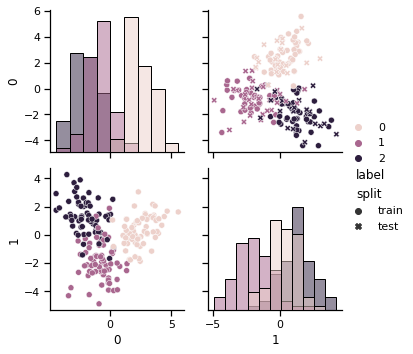

In [12]:
visualize_embeddings(df_preprocessing, step, embedder, k, with_test=True)

# Feature Extraction

In [13]:
fe_steps = [f"feature_extraction__{step}"
            for step in pipeline_arch.feature_extraction]

In [14]:
fe_dfs = [exp_pipe.processed_data_df(step) for step in fe_steps]

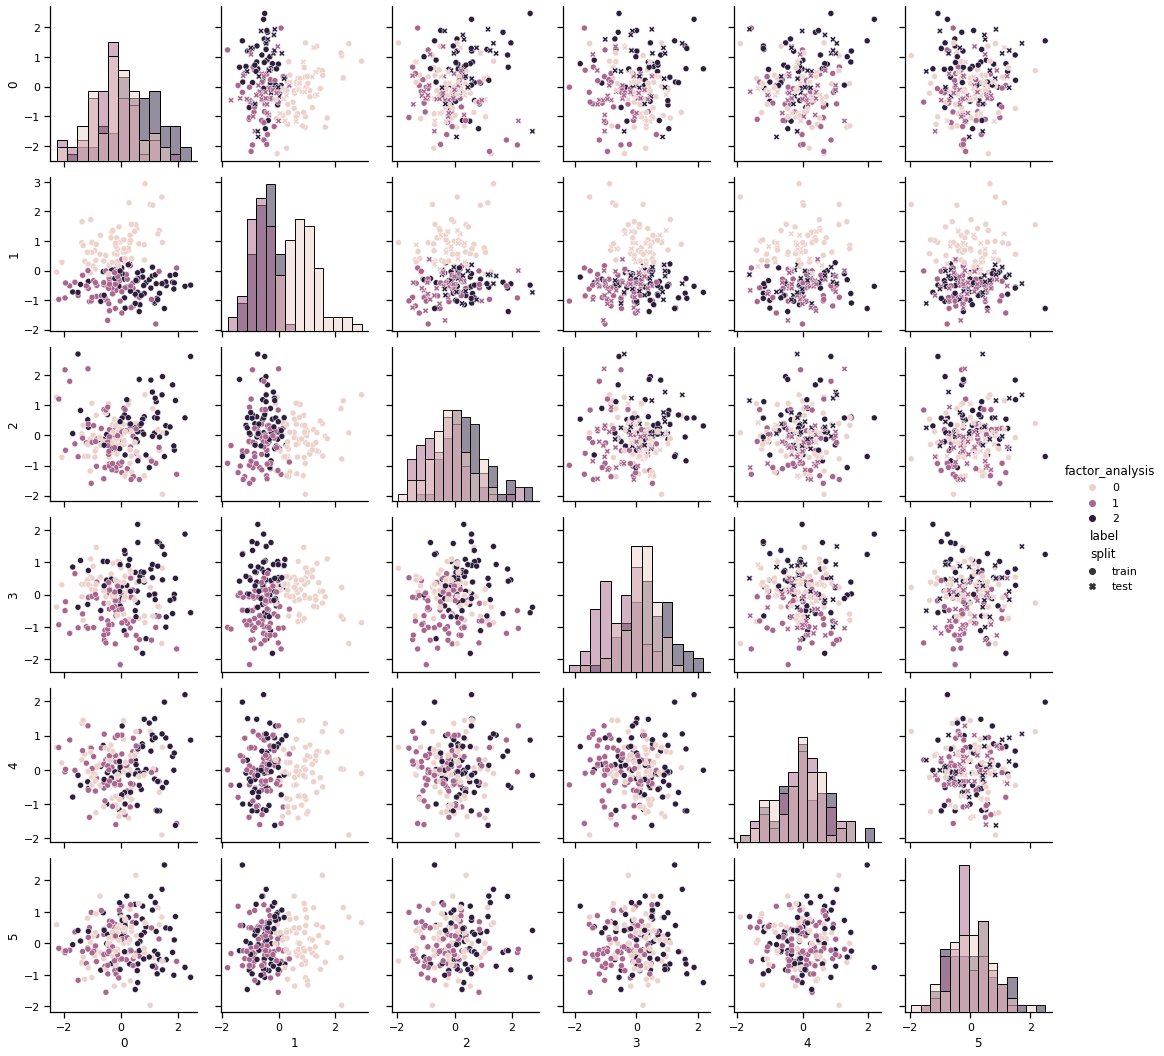

In [15]:
for df, step in zip(fe_dfs, fe_steps):
    title = step.split("__")[-1]
    cols = col_filter(df,k)
    components_pairplot(
        df, 
        cols,
        title=title,
        with_test=True
    )


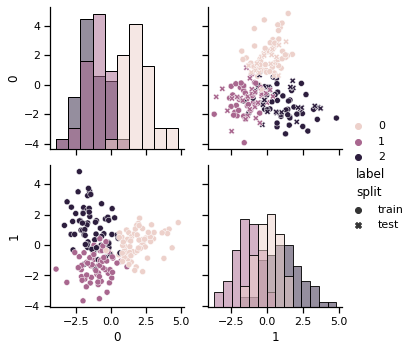

In [16]:
for df, step in zip(fe_dfs, fe_steps):
    visualize_embeddings(df, step, embedder, k, with_test=True)

# Outlier Detection (Isolation Forest)

In [17]:
try:
    insert_step = cfg.extensions.outlier.insert_stage
    outliers_df = get_outliers_df(exp_pipe, insert_step, filter_model)

    cols_to_use = col_filter(outliers_df, k)

    title = "outliers plot"
    components_pairplot(
        outliers_df,
        cols_to_use,
        title=title,
        with_test=False,
        style_col="outlier",
    )
except:
    print("Something went wrong")


Something went wrong
